<a href="https://colab.research.google.com/github/Amina-ban0/Gesture_Recognition/blob/main/Gesture_Recognition_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Loading Required Libaries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Thumbs up:  Increase the volume

1.   Thumbs down: Decrease the volume

1.   Left swipe: 'Jump' backwards 10 seconds
2.   
Right swipe: 'Jump' forward 10 seconds  


2.   Stop: Pause the movie




**Objectives:**

Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

**Model:** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

**Write up:** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [3]:
## Checking the GPU configuration

#!nvidia-smi

In [4]:
# Importing the necessary libraries

import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Gessture Recognistion/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Gessture Recognistion/Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size

**Generator**

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [7]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers

In [8]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))

    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

Let's test the function resize_crop_image by writing a test function

In [9]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))

        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')

        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')

    plt.show()

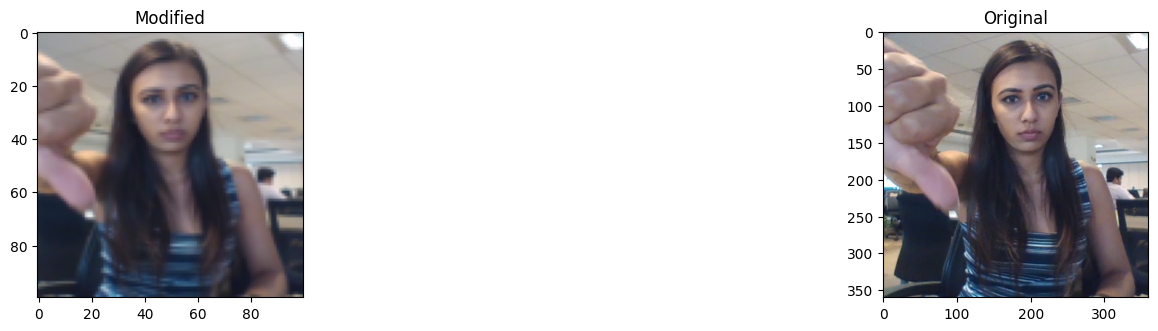

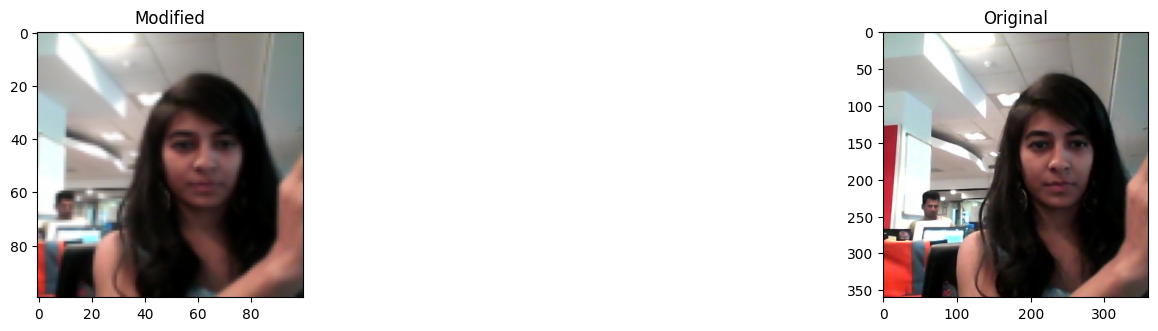

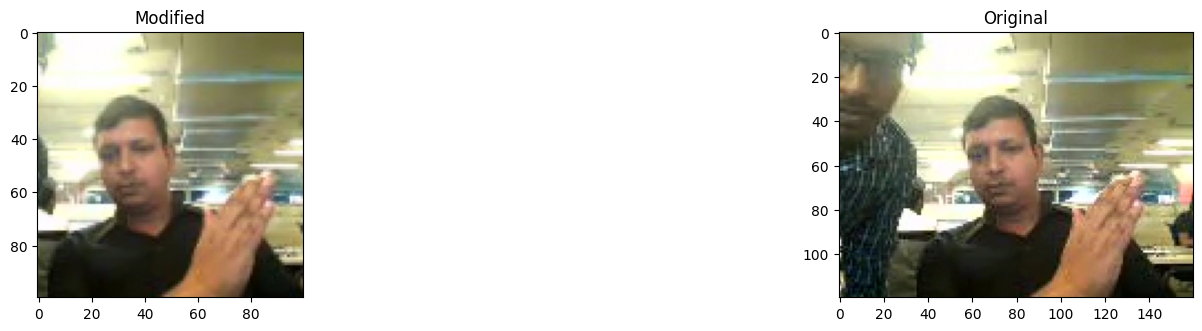

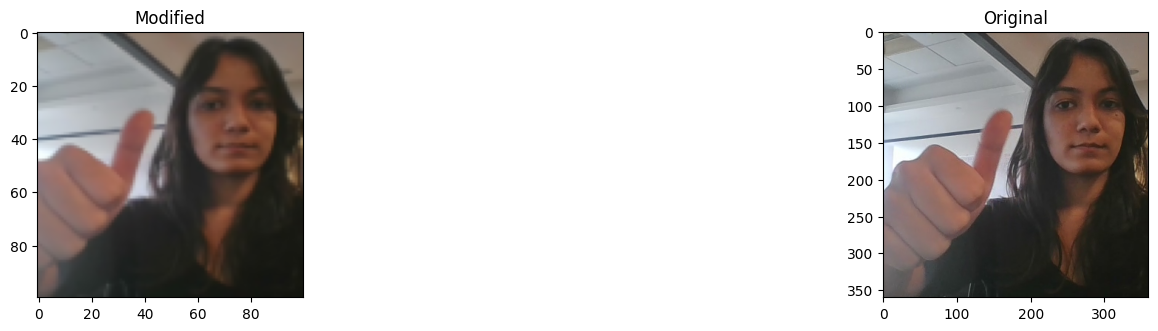

In [10]:
paths = ["/content/drive/MyDrive/Gessture Recognistion/Project_data/train/WIN_20180907_15_53_00_Pro_Thumbs Down_new/WIN_20180907_15_53_00_Pro_00001.png",
        "/content/drive/MyDrive/Gessture Recognistion/Project_data/train/WIN_20180907_15_56_38_Pro_Right Swipe_new/WIN_20180907_15_56_38_Pro_00013.png",
        "/content/drive/MyDrive/Gessture Recognistion/Project_data/train/WIN_20180925_17_22_32_Pro_Right_Swipe_new/WIN_20180925_17_22_32_Pro_00009.png",
        "/content/drive/MyDrive/Gessture Recognistion/Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00011.png"]

show_resize_crop_image(paths)

In [11]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)

            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)

                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Gessture Recognistion/Project_data/train'
val_path = '/content/drive/MyDrive/Gessture Recognistion/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


**Model**
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Experiment 1

In [13]:
pip install tf-agents[reverb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 36.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 51.5 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697629 sha256=51e164553b20b0b13d065c302f2e573aaba856c46133fa2faa5874bb6bbb7eb9
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
  Attempting uninstall: gym
    Fou

In [14]:
import tensorflow
from tensorflow.compat.v1.keras.backend import set_session

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [17]:
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))

In [18]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [19]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization (Batch  (None, 15, 100, 100, 8)   32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 15, 100, 100, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 50, 50, 8)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 16)     3472      
                                                                 
 batch_normalization_1 (Bat  (None, 7, 50, 50, 16)     6

In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Experiment 2

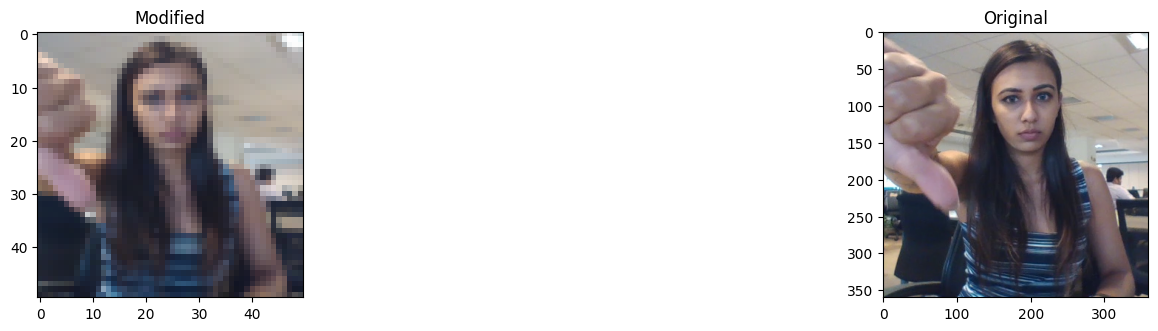

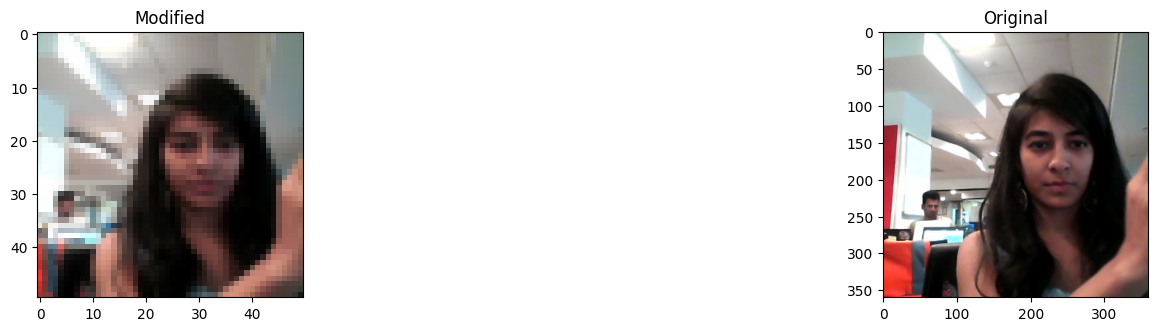

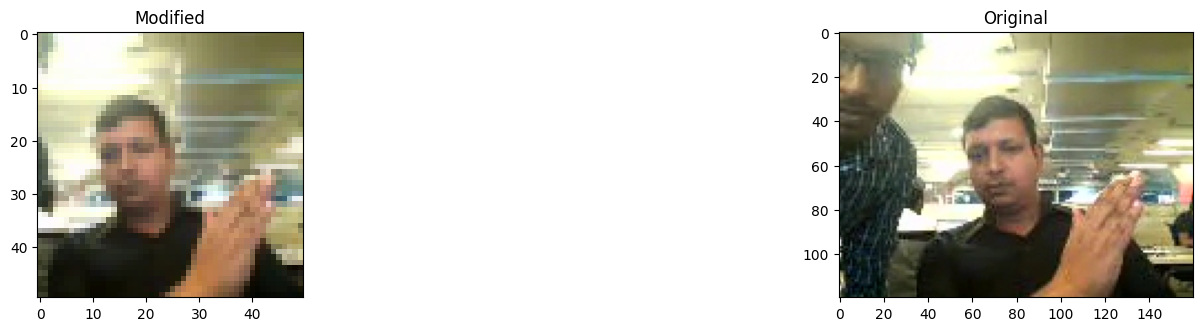

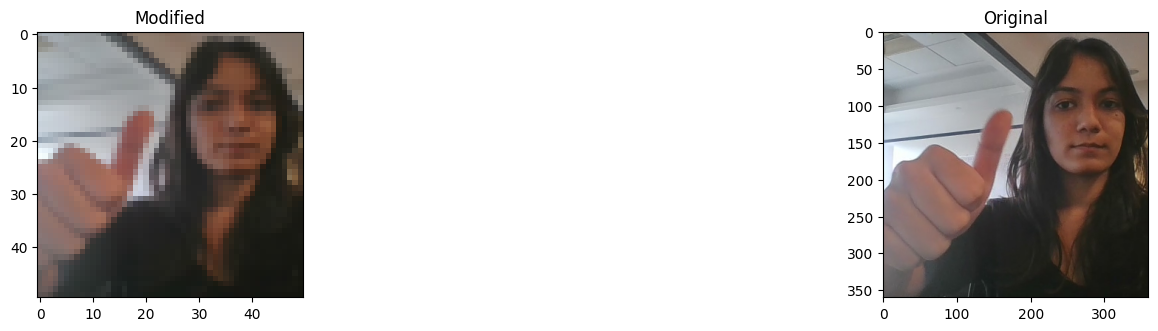

In [26]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [27]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Compiling the model and printing the summary of the model

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [30]:
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))

In [31]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_3 (Bat  (None, 15, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 7, 25, 25, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 25, 25, 16)    

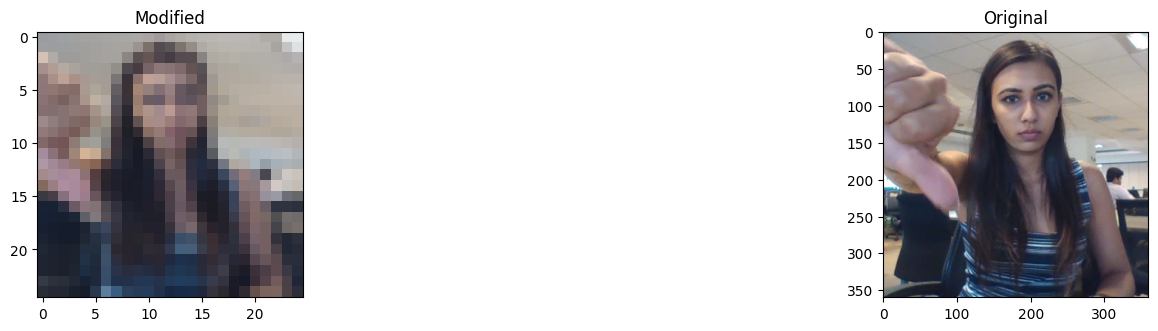

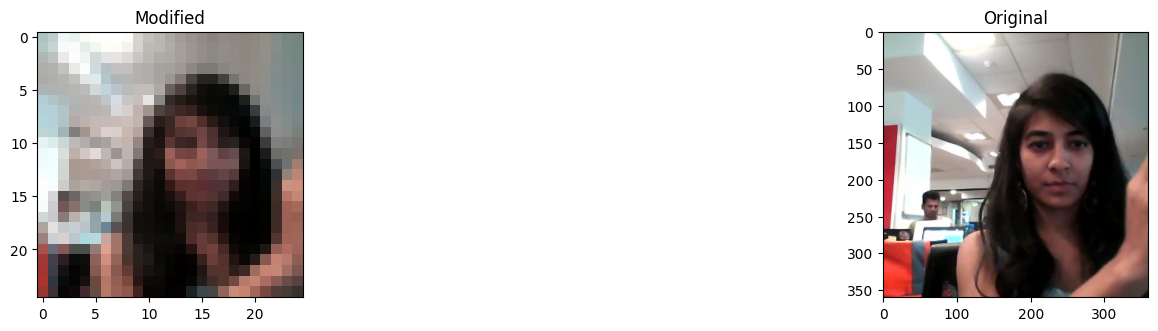

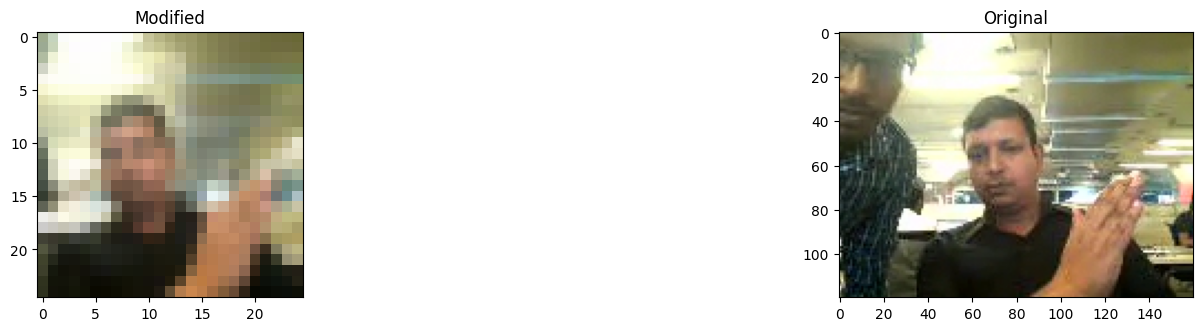

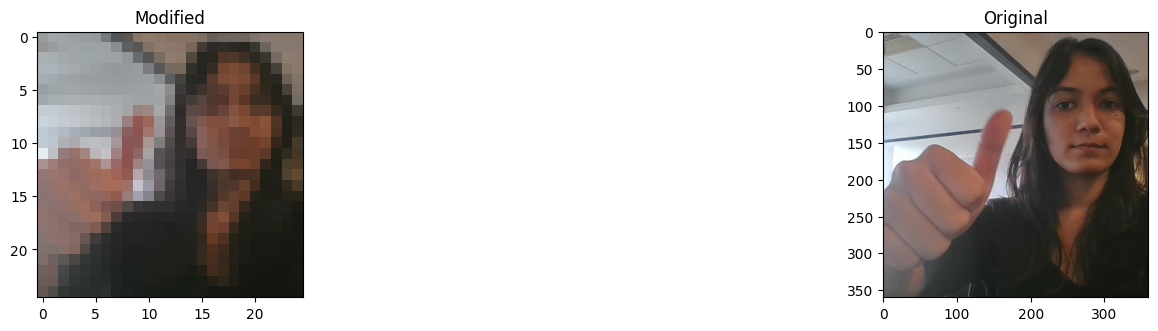

In [33]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [34]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [35]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 25, 25, 8)     656       
                                                                 
 batch_normalization_6 (Bat  (None, 15, 25, 25, 8)     32        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 15, 25, 25, 8)     0         
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 7, 12, 12, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 12, 12, 16)     3472      
                                                                 
 batch_normalization_7 (Bat  (None, 7, 12, 12, 16)    

In [37]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [38]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [39]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [55]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_15 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_16 (Ba  (None, 5, 25, 25, 16)    

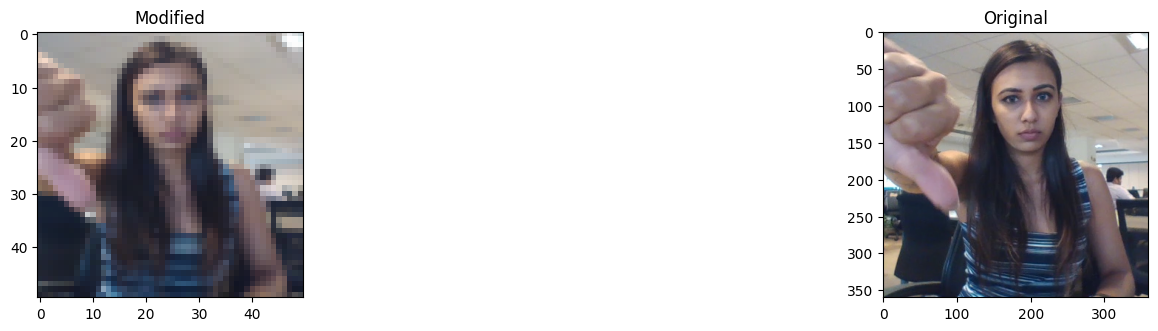

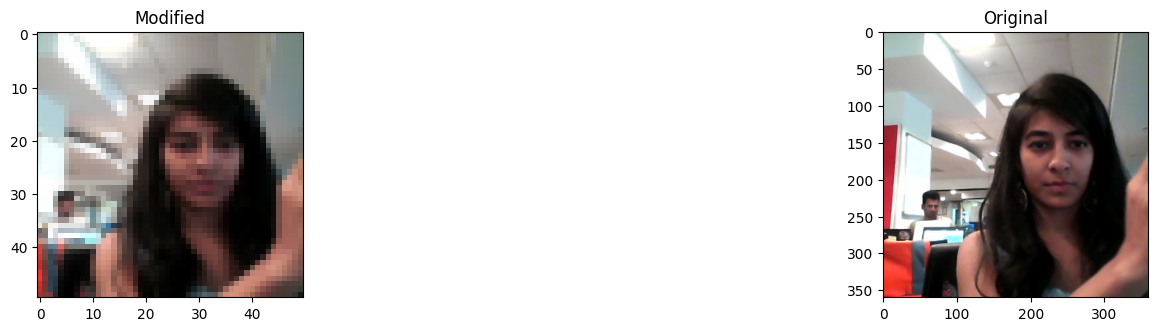

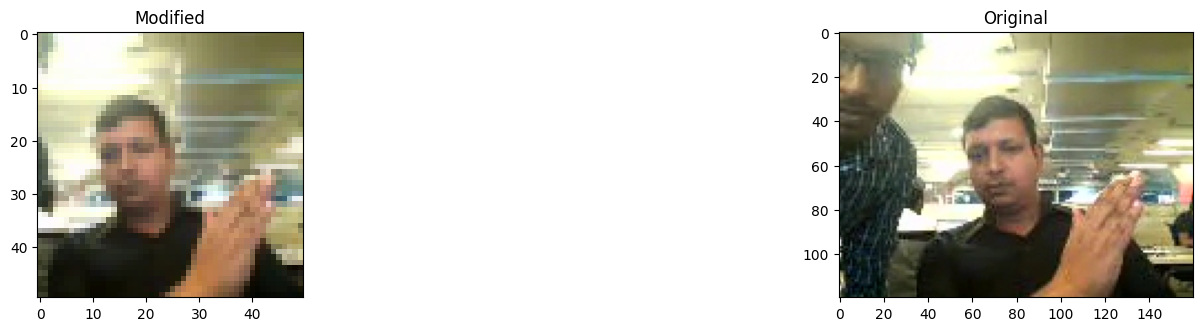

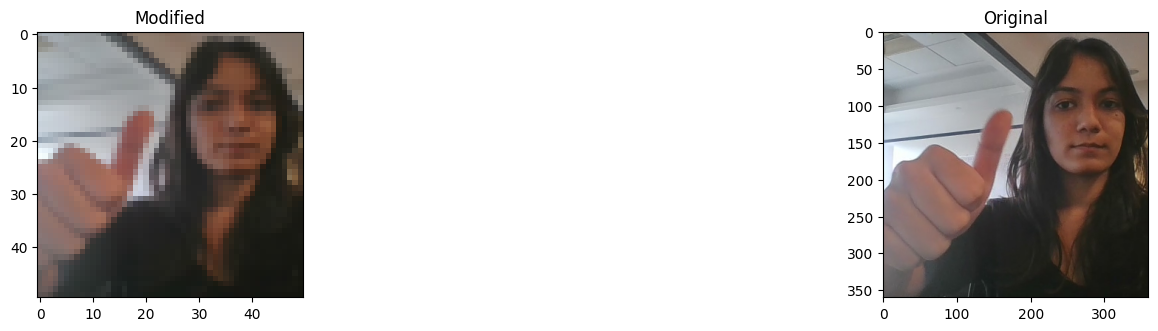

In [40]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

show_resize_crop_image(paths)

In [41]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [42]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [43]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [44]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [56]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_15 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_16 (Ba  (None, 5, 25, 25, 16)    

In [45]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [46]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_12 (Ba  (None, 15, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 7, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_13 (Ba  (None, 7, 25, 25, 16)    

In [47]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [48]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [49]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [57]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_15 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_16 (Ba  (None, 5, 25, 25, 16)    

In [58]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [51]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_15 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_16 (Ba  (None, 5, 25, 25, 16)    

In [52]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [53]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [54]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [59]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_15 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_16 (Ba  (None, 5, 25, 25, 16)    

In [60]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [61]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_18 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_18 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_19 (Ba  (None, 5, 25, 25, 16)    

In [62]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [63]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [64]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_18 (Ba  (None, 10, 50, 50, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_18 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_19 (Ba  (None, 5, 25, 25, 16)    